In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import STATES

from distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38309,Workers: 4
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:35277,Total threads: 1
Dashboard: /user/jbusecke/proxy/33207/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:41413,


In [2]:

import xarray as xr

store = 'https://carbonplan-data-viewer.s3.amazonaws.com/demo/ScenarioMIP.CCCma.CanESM5.ssp245.r1i1p1f1.annual.GARD-SV.tasmax.zarr'
ds = xr.open_dataset(store, engine='zarr', chunks={})


In [3]:
ds

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, time: 85)
Coordinates:
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 2015-01-01 2016-01-01 ... 2099-01-01
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(85, 128, 128), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                     CF-1.8
    activity_id:                     ScenarioMIP
    cmip6_downscaling_contact:       hello@carbonplan.org
    cmip6_downscaling_explainer:     https://carbonplan.org/research/cmip6-do...
    cmip6_downscaling_institution:   CarbonPlan
    cmip6_downscaling_license:       CC-BY-4.0
    ...                              ...
    institution_id:                  CCCma
    member_id:                       r1i1p1f1
    references:                      Eyring, V., Bony, S., Meehl, G. A., Seni...
    source_id:                       CanESM5
    timescale:                       day
    variable_id:                     tasmax

## Maximum daily temperature in NYC over time

Text(0.5, 1.0, 'Surface Temperature in NYC')

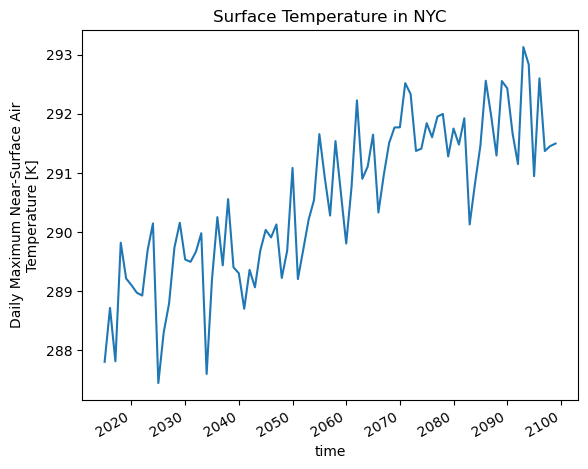

In [4]:
lat_nyc, lon_nyc = 40.7128, -74.0060

def nyc_timeseries(da):
    return da.sel(lon=lon_nyc, lat=lat_nyc, method='nearest')

# timeseries
ds.tasmax.pipe(nyc_timeseries).plot()
plt.title('Surface Temperature in NYC')

### Adding an additional dataset - Precipitation

Text(0.5, 1.0, 'Change in Precipitation (last decade vs first)')

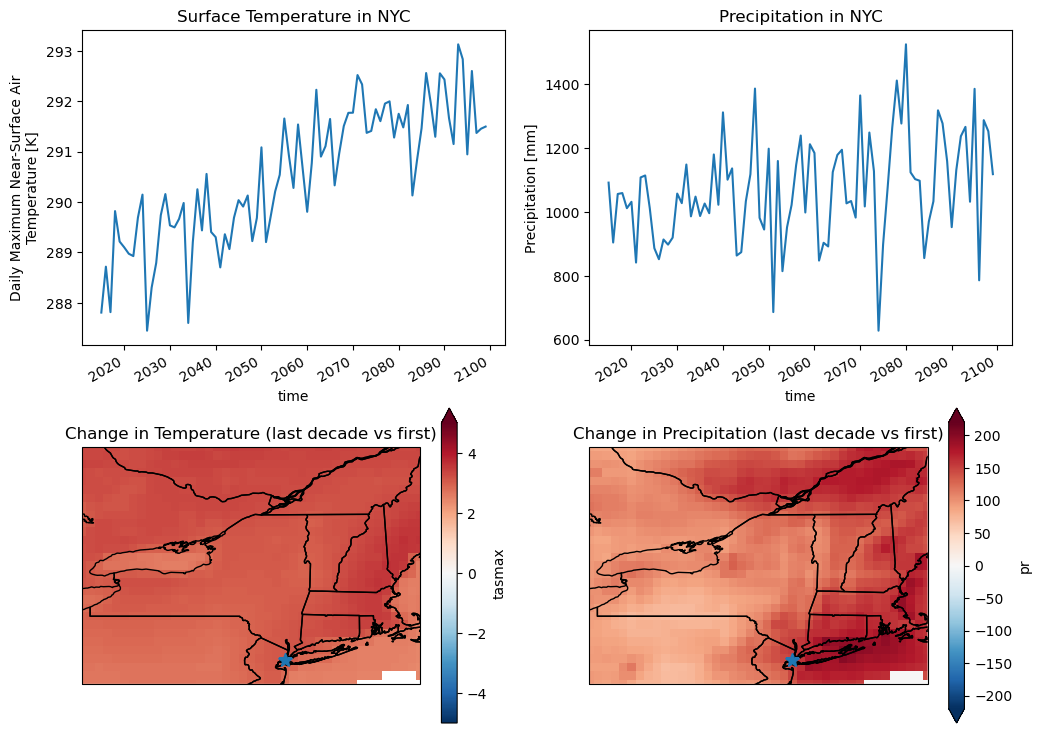

In [5]:
# load a second dataset for precipitation
store = 'https://carbonplan-data-viewer.s3.amazonaws.com/demo/ScenarioMIP.CCCma.CanESM5.ssp245.r1i1p1f1.annual.GARD-SV.pr.zarr'
ds_precip = xr.open_dataset(store, engine='zarr', chunks={})

plt.figure(figsize=[12,9])

# temperature timeseries
plt.subplot(2,2,1)
ds.tasmax.pipe(nyc_timeseries).plot()
plt.title('Surface Temperature in NYC')

# precipitation timeseries
plt.subplot(2,2,2)
ds_precip.pr.pipe(nyc_timeseries).plot()
plt.title('Precipitation in NYC')


# plot maps showing the difference between a 10 year average at the end of the century vs the beginning
def difference_map(da):
    da_end = da.sel(time=slice('2085', '2095')).mean('time', keep_attrs=True)
    da_start = da.sel(time=slice('2015', '2025')).mean('time', keep_attrs=True)
    return da_end - da_start

ax = plt.subplot(2,2,3, projection=ccrs.PlateCarree())
ds.tasmax.pipe(difference_map).plot(center=0, vmax=5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -70, 40, 47])
ax.add_feature(STATES)
ax.plot(lon_nyc, lat_nyc, marker='*', markersize=10)
ax.set_title('Change in Temperature (last decade vs first)')

ax = plt.subplot(2,2,4, projection=ccrs.PlateCarree())
ds_precip.pr.pipe(difference_map).plot(center=0, vmax=220, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -70, 40, 47])
ax.add_feature(STATES)
ax.plot(lon_nyc, lat_nyc, marker='*', markersize=10)
ax.set_title('Change in Precipitation (last decade vs first)')